# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [104]:
!pip install networkx==2.3

In [105]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import stellargraph
# you need to have tensorflow 1.x +
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [106]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [107]:
edges = [tuple(x) for x in data.values.tolist()]

In [108]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [109]:
A = [B.subgraph(c) for c in nx.connected_components(B)] 
A = list(A)[0]

In [110]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


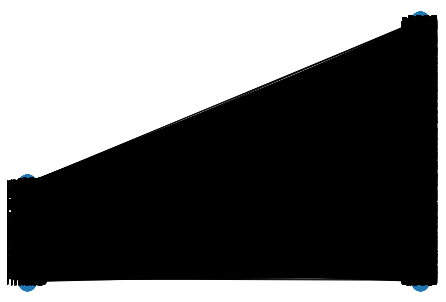

In [111]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [112]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [113]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [114]:
from gensim.models import Word2Vec
model = Word2Vec(walks, vector_size=128, window=5)

In [115]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [116]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [A.nodes[node_id]['label'] for node_id in node_ids]

In [117]:
print(node_ids[:15])

['a973', 'a967', 'a964', 'a970', 'a1731', 'a969', 'a1028', 'a965', 'm1111', 'a1057', 'a1003', 'm1094', 'a966', 'a959', 'a988']


In [118]:
print(node_targets[:15])

['actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'movie', 'actor', 'actor', 'movie', 'actor', 'actor', 'actor']


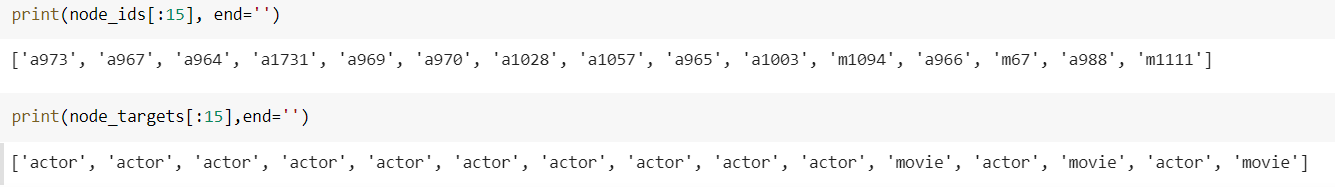

In [119]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes, movie_nodes=[], []
    actor_embeddings, movie_embeddings=[], []
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie_embedding done
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    
    
    for index, node in enumerate(node_targets):
        if node == 'actor':
            actor_embeddings.append(node_embeddings[index])
            actor_nodes.append(node_ids[index])

        elif node == 'movie':
            movie_embeddings.append(node_embeddings[index])
            movie_nodes.append(node_ids[index])
    
    return actor_nodes, movie_nodes, actor_embeddings, movie_embeddings


In [120]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

In [121]:
actor_embeddings = np.array(actor_embeddings)
actor_embeddings.shape

(3411, 128)

<font color='cyan'>Grader function - 1</font>

In [122]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [123]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [124]:
def cost1(graph, number_of_clusters):
    '''In this function, we will calculate cost1'''
    for i in range(number_of_clusters):
        cost1 = len(max(nx.connected_components(graph), key=len)) / graph.number_of_nodes() 
    cost1 = (1/number_of_clusters) * cost1
    return cost1

<img src='https://i.imgur.com/4SPYPFa.jpg'>

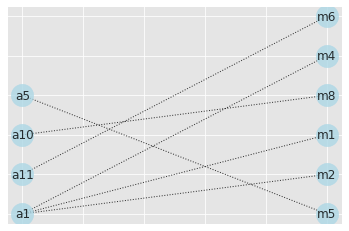

In [125]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [126]:
graded_cost1=cost1(graded_graph, 3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [127]:
def cost2(graph, number_of_clusters):
    '''In this function, we will calculate cost1'''
    for j in range(number_of_clusters):
        number_of_movie_nodes = len(set([i for i in graph.nodes() if 'm' in i]))
        number_of_actor_nodes = len(set([i for i in graph.nodes() if 's' in i]))
        cost2= graph.number_of_edges() / number_of_movie_nodes # something wrong with the numerator
    cost2 = 1/number_of_clusters * cost2

    return cost2

<font color='cyan'>Grader function - 4</font>

In [128]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

<font color='blue'>Grouping similar actors</font>

In [129]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

listOfclusters = [3, 5, 10, 30, 50, 100, 200, 500]

for number_of_clusters in listOfclusters:
    clustering = KMeans(n_clusters=number_of_clusters).fit(actor_embeddings)
    cost_uno = 0
    cost_dos = 0
    listOftotalCost = []

    for sub_cluster in range(number_of_clusters):
        ego_edges = []
        movies_in_cluster = set()
        actors_in_cluster = set()

        for index, label in enumerate(clustering.labels_):
            if label == sub_cluster:
                ego_edges.append(nx.ego_graph(B, actor_nodes[index]).edges)
            all_edges = [tuple(j) for i in range(len(ego_edges)) for j in ego_edges[i]]

        for i, j in all_edges:
            if "m" in i:
                movies_in_cluster.add(i)
                actors_in_cluster.add(j)
            else:
                actors_in_cluster.add(i)
                actors_in_cluster.add(j)

        sub_cluster_graph = nx.Graph()
        sub_cluster_graph.add_nodes_from(actors_in_cluster, bipartite=0)
        sub_cluster_graph.add_nodes_from(movies_in_cluster, bipartite=1)
        sub_cluster_graph.add_edges_from(all_edges)

        cost_uno += cost1(sub_cluster_graph, number_of_clusters)
        cost_dos += cost2(sub_cluster_graph, number_of_clusters)
        
        total_cost = cost_uno*cost_dos
    listOftotalCost.append(float(total_cost))
        
    print("For k = {0}, cost1 = {1} and cost2 = {2}. Total cost = {3}".format(
           number_of_clusters, cost_uno, cost_dos, cost_uno * cost_dos))

For k = 3, cost1 = 0.9116898080414493 and cost2 = 4.0928339261767235. Total cost = 3.7313949765015884
For k = 5, cost1 = 0.9476125498928598 and cost2 = 3.2928393856625937. Total cost = 3.1203359266353683
For k = 10, cost1 = 0.8081844510239292 and cost2 = 2.515443932132411. Total cost = 2.0329426733719065
For k = 30, cost1 = 0.8839239117691469 and cost2 = 1.874843156133215. Total cost = 1.6572186965228848
For k = 50, cost1 = 0.8553918829515942 and cost2 = 2.1328936854414535. Total cost = 1.82445994572533
For k = 100, cost1 = 0.8681416598888065 and cost2 = 1.704108395574273. Total cost = 1.4794074911643003
For k = 200, cost1 = 0.8529793558726715 and cost2 = 1.9150719538303316. Total cost = 1.6335168416280146
For k = 500, cost1 = 0.9088336800621863 and cost2 = 2.0708701726663925. Total cost = 1.8820765599554128


In [130]:
listOfcosts = [3.741527226031437, 3.1041061133977483, 2.320610372336529, 1.6667005605944016, 1.5825697322586463, 1.7527874968003587, 1.7266339086283995, 1.8675912752565003]

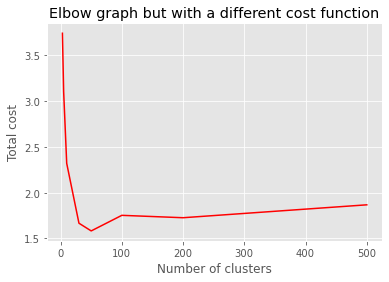

In [131]:
# mpl.rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y'])
with plt.style.context('ggplot'):

    plt.plot(listOfclusters, listOfcosts, color='r')
    plt.xlabel('Number of clusters')
    plt.ylabel('Total cost')
    plt.title('Elbow graph but with a different cost function')
    plt.show()

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<font color='blue'>Displaying similar actor clusters</font>

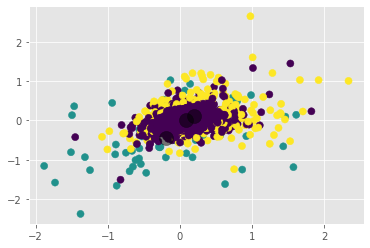

In [132]:
from matplotlib import style
plt.style.use('seaborn-muted')

kmeans = KMeans(n_clusters=3).fit(actor_embeddings)
labels = kmeans.labels_

y_kmeans = kmeans.predict(actor_embeddings)

plt.scatter(actor_embeddings[:, 0], actor_embeddings[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [133]:
from sklearn.manifold import TSNE
transform = TSNE 

trans = transform(n_components=2)
actor_embeddings_2d = trans.fit_transform(actor_embeddings)

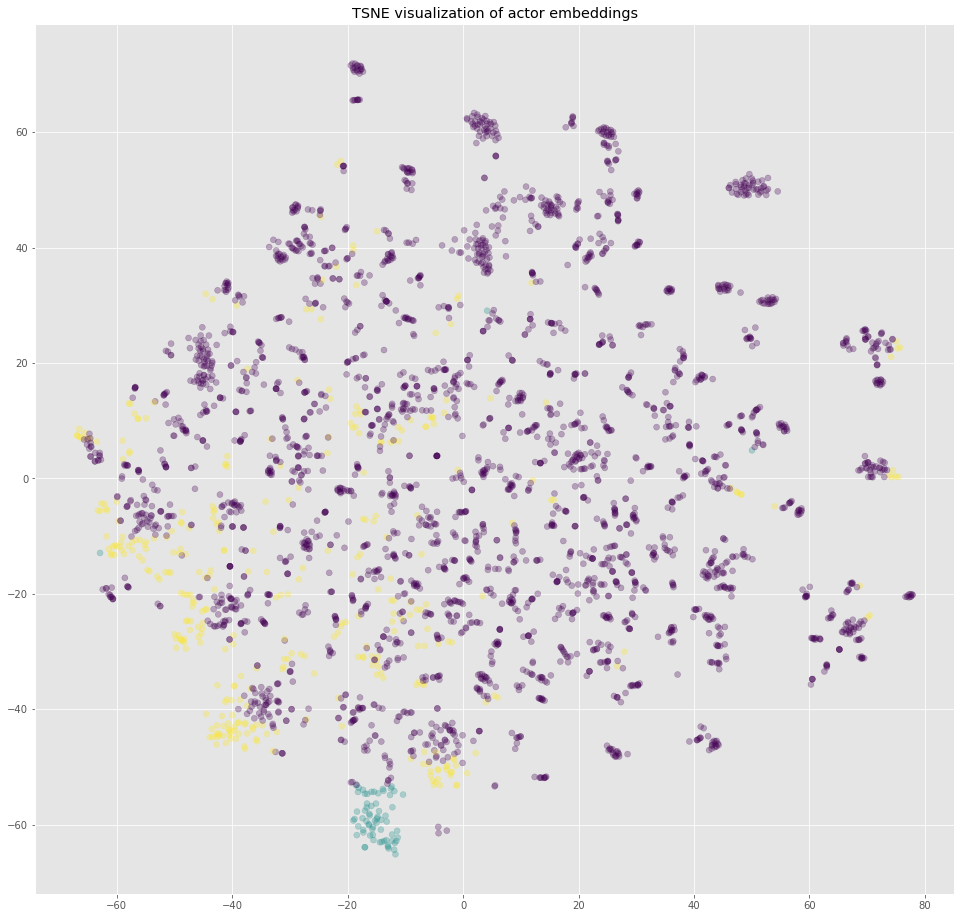

In [134]:
import numpy as np
# draw the points
plt.style.use('seaborn-muted')

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(actor_embeddings_2d[:,0], 
            actor_embeddings_2d[:,1], 
            c=labels, alpha=0.3)
plt.title('{} visualization of actor embeddings'.format(transform.__name__))

plt.show()

<font color='blue'>Grouping similar movies</font>

In [135]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

listOfclusters = [3, 5, 10, 30, 50, 100, 200, 500]

for number_of_clusters in listOfclusters:
    clustering = KMeans(n_clusters=number_of_clusters).fit(movie_embeddings)
    cost_uno = 0
    cost_dos = 0
    listOftotalCost = []

    for sub_cluster in range(number_of_clusters):
        ego_edges = []
        movies_in_cluster = set()
        actors_in_cluster = set()

        for index, label in enumerate(clustering.labels_):
            if label == sub_cluster:
                ego_edges.append(nx.ego_graph(B, movie_nodes[index]).edges)
            all_edges = [tuple(j) for i in range(len(ego_edges)) for j in ego_edges[i]]

        for i, j in all_edges:
            if "m" in i:
                movies_in_cluster.add(i)
                actors_in_cluster.add(j)
            else:
                actors_in_cluster.add(i)
                actors_in_cluster.add(j)

        sub_cluster_graph = nx.Graph()
        sub_cluster_graph.add_nodes_from(movies_in_cluster, bipartite=0)
        sub_cluster_graph.add_nodes_from(actors_in_cluster, bipartite=1)
        sub_cluster_graph.add_edges_from(all_edges)

        cost_uno += cost1(sub_cluster_graph, number_of_clusters)
        cost_dos += cost2(sub_cluster_graph, number_of_clusters)
        
        total_cost = cost_uno*cost_dos
    listOftotalCost.append(float(total_cost))
        
    print("For k = {0}, cost1 = {1} and cost2 = {2}. Total cost = {3}".format(
           number_of_clusters, cost_uno, cost_dos, cost_uno * cost_dos))

For k = 3, cost1 = 0.9756151426717908 and cost2 = 8.5412799661969. Total cost = 8.333002072820896
For k = 5, cost1 = 0.9673664973787439 and cost2 = 8.956714813626865. Total cost = 8.66442583727853
For k = 10, cost1 = 0.9272704632243067 and cost2 = 9.995598237670096. Total cost = 9.268623008048413
For k = 30, cost1 = 0.945445059371735 and cost2 = 13.896623448985. Total cost = 13.138493981792267
For k = 50, cost1 = 0.9586435758366204 and cost2 = 13.22627361038387. Total cost = 12.679282228851921
For k = 100, cost1 = 0.973600772952629 and cost2 = 14.636930533928137. Total cost = 14.25052688148637
For k = 200, cost1 = 0.9883276102506365 and cost2 = 12.842090215403575. Total cost = 12.692192333212898
For k = 500, cost1 = 0.9939883182155616 and cost2 = 10.527680643251443. Total cost = 10.464391577296023


<font color='blue'>Displaying similar movie clusters</font>

In [136]:
movie_embeddings = np.array(movie_embeddings)

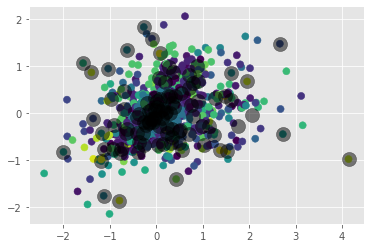

In [138]:
from matplotlib import style
plt.style.use('seaborn-muted')

kmeans = KMeans(n_clusters=100).fit(movie_embeddings)
labels = kmeans.labels_
y_kmeans = kmeans.predict(movie_embeddings)

plt.scatter(movie_embeddings[:, 0], movie_embeddings[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [139]:
from sklearn.manifold import TSNE
transform = TSNE 

trans = transform(n_components=2)
movie_embeddings_2d = trans.fit_transform(movie_embeddings)

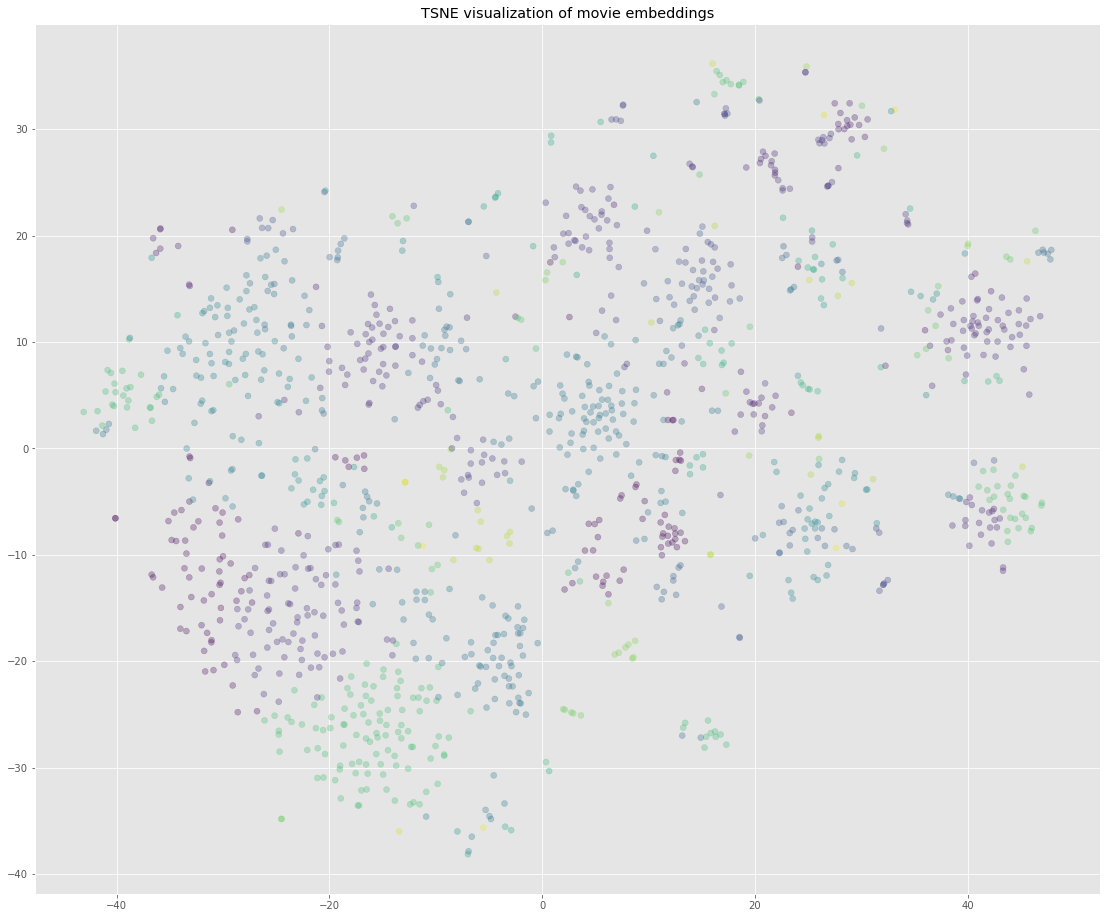

In [140]:
import numpy as np
# draw the points
plt.style.use('seaborn-muted')

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(movie_embeddings_2d[:,0], 
            movie_embeddings_2d[:,1], 
            c=labels, alpha=0.3)
plt.title('{} visualization of movie embeddings'.format(transform.__name__))

plt.show()